### OpenFace 2.0

To use OpenFace 2.0:
- Download via [Github](https://github.com/TadasBaltrusaitis/OpenFace/wiki), install via [Win Install](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Windows-Installation) and [Model File](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Model-download)
- Output format [Github](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Output-Format) (Most important is CSV file)
- For this case:
  - open cmd, locate dir `cd C:\.. [dir here]` (for my case: 
`cd C:\Users\yiche\Downloads\OpenFace_2.2.0_win_x64\OpenFace_2.2.0_win_x64`)
  - for single file `FeatureExtraction.exe -f "dir\filename.mp4" -pose -gaze -aus`
  - for multiple files `for %f in ("dir\*.mp4") do FeatureExtraction.exe -f "%f" -pose -gaze -aus`

Note on data-processing:
- Make sure it got label before copy & process data
- Data is saved, when the `csv` file is 300 lines, usually ~700 KB
- Data is deleted, when the `csv` file is large (more than 300 lines, usually ~5-20 MB)
- After OpenFace processed the videos, we no longer need it afterwards (only csv file will be used for model training)

In OpenFace output CSV File:
- Important info are gaze, head, au
- Parameters used are `gaze_direction`, `gaze_angle`, `head_pose_xy`, `head_pose_theta`, `au` (Currently `lmk`, `pdm` are not used)
  - gaze: Gaze Direction
  - head: Head Pose (XY & Theta)
  - au: Action Units
  - lmk: Landmarks
  - pdm: Probability Distribution Matrices
- `mean` and `std` are calculated for each parameter

### Input and Output
**Data-split (data->train,test,val)**, it's handled by `data_loader_v1` within `data_prep.ipynb`, for this code, just required 1 overall labelling `xlsx` file

Input files:
- OpenFace `csv` files folder (1 folder, all files inside)
- Label `xlsx` file (1 file)

Output files:
- save the processed file as `npy` format, namely:
  - `gaze+hp.npy`
  - `gaze+hp+au.npy` (This is used)

### Extract Features

Feature Types are:
- `gaze+hp`
- `gaze+hp+au`
- `gaze+hp+au+lmk` (not used)
- `gaze+hp+au+lmk+pdm` (not used)

### Functions
`get_features(input_segment, features)`:
- Extracts various statistics (mean, standard deviation) from the specified features for a given segment of input data.
- Supports different combinations of features (gaze, head pose, action units, landmarks, etc.).

`parse_features(openface_feature_file_path, features)`:
- Reads and processes an OpenFace CSV file, splits the data into 10 equal segments, and calls get_features() on each segment.
- It returns the extracted features for all segments in the video.

`extract_features_engage(feature_type)`:
- Main function that loops through video chunks, extracts features, and adds them to the dataset along with the labels.
- It handles errors related to missing files or assertion errors.

In [1]:
import glob
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

n_segments = 10
label_path = 'EmotiW2023 Data Small/engagement_labels.xlsx'  # label xlsx file here
openface_folderpath = 'EmotiW2023 Data Small/openface/'      # Openface csv files here
openface_test_path = 'EmotiW2023 Data Small/openface/subject_2_thw33jke4j_vid_0_0.csv'

In [2]:
def get_features(input_segment, features):
    if len(input_segment) == 0:
        return []
    input_segment = input_segment.astype(float)
    
    gaze_direction = input_segment[:, 5:11]
    gaze_angle = input_segment[:, 11:13]
    
    gaze_direction_std = np.std(gaze_direction, axis=0)
    gaze_dircetion_mean = np.mean(gaze_direction, axis=0)
    
    gaze_angle_std = np.std(gaze_angle, axis=0)
    gaze_angle_mean = np.mean(gaze_angle, axis=0)
    
    head_pose_xy_std = np.std(input_segment[:, 293:296], axis=0) 
    head_pose_xy_mean = np.mean(input_segment[:, 293:296], axis=0)

    head_pose_theta_std = np.std(input_segment[:, 296: 299], axis=0) 
    head_pose_theta_mean = np.mean(input_segment[:, 296: 299], axis=0)

    au = input_segment[:, 299:] # original val: 679
    au_mean = np.mean(au, axis=0)
    au_std = np.std(au, axis=0)

    # lmk_mean = np.mean(input_segment[:, 299: 435], axis=0)
    # lmk_std = np.std(input_segment[:, 299: 435], axis=0)
    
    # pdm = input_segment[:, 639: 679]
    # pdm_mean = np.mean(pdm, axis=0)
    # pdm_std = np.std(pdm, axis=0)
    
    if features == "gaze+hp+au":
        segment_features = np.hstack((
            gaze_direction_std, 
            gaze_dircetion_mean, 
            gaze_angle_std, 
            gaze_angle_mean,
            head_pose_xy_std,
            head_pose_xy_mean,
            head_pose_theta_std,
            head_pose_theta_mean,
            au_mean, 
            au_std))
        
        return segment_features
    
    elif features == "gaze+hp":
        segment_features = np.hstack((
                                      gaze_dircetion_mean,
                                      gaze_direction_std,
                                      head_pose_xy_std,
                                      head_pose_xy_mean,
                                      head_pose_theta_std,
                                      head_pose_theta_mean,
                                    ))
        return segment_features
    """
    elif features == 'gaze+hp+au+lmk':
        segment_features = np.hstack((gaze_dircetion_mean,
                                      gaze_direction_std,
                                      gaze_angle_std, 
                                      gaze_angle_mean,
                                      
                                      head_pose_xy_std,
                                      head_pose_xy_mean,
                                      head_pose_theta_std,
                                      head_pose_theta_mean,
                                      au_mean, 
                                      au_std,
                                      
                                      lmk_mean, 
                                      lmk_std))
        return segment_features
    elif features == 'gaze+hp+au+lmk+pdm':
        segment_features = np.hstack((gaze_dircetion_mean,
                                      gaze_direction_std,
                                      gaze_angle_std, 
                                      gaze_angle_mean,
                                      
                                      head_pose_xy_std,
                                      head_pose_xy_mean,
                                      head_pose_theta_std,
                                      head_pose_theta_mean,
                                      au_mean, 
                                      au_std,
                                      
                                      lmk_mean, 
                                      lmk_std,
                                     
                                      pdm_mean,
                                      pdm_std))
        return segment_features
    """

In [3]:
def parse_features(openface_feature_file_path, features):
    
    df = pd.read_csv(openface_feature_file_path).dropna()
    df.columns = [i.strip() for i in list(df.columns)]
    df = df[df['confidence']>0.95].values

    window_size = int(df.shape[0]/n_segments)
    if window_size < 1:
        return (openface_feature_file_path, [])
    instance_features = []
    start_index = 0
    for i in range(n_segments):
        if i == n_segments - 1:
            end_index = df.shape[0]
        else:
            end_index = start_index + window_size
        
        # update here for our dataset
        index_features = get_features(df[start_index:end_index, :], features)
        if len(index_features):
            instance_features.append(index_features)
        start_index = start_index + window_size
    
    
    instance_features = np.vstack(instance_features)
#     assert instance_features.shape[0] == 20, "shape issue"
    return instance_features

In [4]:
def path_to_csv(fname):
    return fname.split('.mp4')[0] + '.csv'
def path_to_mp4(fname):
    return fname.split('.csv')[0] + '.mp4'

In [17]:
_errors_ = []
def extract_features_engage(feature_type):
    labels = pd.read_excel(label_path, index_col=0)
    data = []
    for f in tqdm(labels.to_dict(orient='records')):

        try:
            fname = path_to_csv(f['chunk'])
            fname = openface_folderpath + fname.split('/')[-1]
            features = parse_features(fname, feature_type)
            data.append((fname, 
                         features, 
                         f['label']
                       ))
        except FileNotFoundError:
            _errors_.append(fname)
        except AssertionError:
            print ("assert: ", _file)
    return data

In [19]:
# Load the data, might take a while
feature_type = 'gaze+hp+au' # can select: gaze+hp, gaze+hp+au
data = extract_features_engage(feature_type)

100%|██████████████████████████████████████████████████████████████████████████████| 8040/8040 [06:47<00:00, 19.73it/s]


In [20]:
print(data[0])
print(len(data),len(data[0]))

('EmotiW2023 Data Small/openface/subject_68_0ng3yqwrg6_vid_0_0.csv', array([[ 2.74839246e-02,  3.11073475e-02,  6.83718190e-03,
         3.71045516e-02,  1.41504290e-02,  2.13554934e-03,
         1.58760458e-01,  1.24095583e-01, -9.78583375e-01,
        -5.56122083e-02,  1.26766458e-01, -9.89573667e-01,
         2.87473429e-02,  2.07845679e-02,  5.24166667e-02,
         1.26791667e-01,  8.68657569e-01,  2.95613475e+00,
         6.27394856e+00, -2.40958333e+01,  5.46291667e+01,
         3.38591667e+02,  4.91578382e-03,  2.89035753e-03,
         2.58165268e-03,  6.20833333e-03, -6.52500000e-02,
         8.45416667e-02,  2.45833333e-02,  1.66666667e-03,
         1.15500000e+00,  0.00000000e+00,  9.51250000e-01,
         4.60833333e-01,  3.75000000e-03,  1.45333333e+00,
         7.66250000e-01,  1.53875000e+00,  3.33333333e-02,
         1.98333333e-01,  0.00000000e+00,  1.62500000e-02,
         1.66666667e-03,  3.45000000e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.0

In [21]:
for idx, d in enumerate(data):
    #data[idx] = ('chunks/' + path_to_mp4(d[0]).split('/')[-1], d[1], d[2])
    #data[idx] = (path_to_mp4(d[0]).split('/')[-1], d[1], d[2])
    data[idx] = (path_to_mp4(d[0]).split('/')[-1], d[1], d[2])

npy files:
- EmotiW2023 Data Small/Xy_engage_gaze+hp+au.npy
- EmotiW2023 Data Small/Xy_engage_gaze+hp.npy

In [22]:
np.save(f'EmotiW2023 Data Small/Xy_engage_{feature_type}_10.npy', np.array(data, dtype='object'))

In [23]:
# Test csv data
df = pd.read_csv(openface_test_path)
dict(zip(range(len(df.columns)), list(df.columns)))

{0: 'frame',
 1: ' face_id',
 2: ' timestamp',
 3: ' confidence',
 4: ' success',
 5: ' gaze_0_x',
 6: ' gaze_0_y',
 7: ' gaze_0_z',
 8: ' gaze_1_x',
 9: ' gaze_1_y',
 10: ' gaze_1_z',
 11: ' gaze_angle_x',
 12: ' gaze_angle_y',
 13: ' eye_lmk_x_0',
 14: ' eye_lmk_x_1',
 15: ' eye_lmk_x_2',
 16: ' eye_lmk_x_3',
 17: ' eye_lmk_x_4',
 18: ' eye_lmk_x_5',
 19: ' eye_lmk_x_6',
 20: ' eye_lmk_x_7',
 21: ' eye_lmk_x_8',
 22: ' eye_lmk_x_9',
 23: ' eye_lmk_x_10',
 24: ' eye_lmk_x_11',
 25: ' eye_lmk_x_12',
 26: ' eye_lmk_x_13',
 27: ' eye_lmk_x_14',
 28: ' eye_lmk_x_15',
 29: ' eye_lmk_x_16',
 30: ' eye_lmk_x_17',
 31: ' eye_lmk_x_18',
 32: ' eye_lmk_x_19',
 33: ' eye_lmk_x_20',
 34: ' eye_lmk_x_21',
 35: ' eye_lmk_x_22',
 36: ' eye_lmk_x_23',
 37: ' eye_lmk_x_24',
 38: ' eye_lmk_x_25',
 39: ' eye_lmk_x_26',
 40: ' eye_lmk_x_27',
 41: ' eye_lmk_x_28',
 42: ' eye_lmk_x_29',
 43: ' eye_lmk_x_30',
 44: ' eye_lmk_x_31',
 45: ' eye_lmk_x_32',
 46: ' eye_lmk_x_33',
 47: ' eye_lmk_x_34',
 48: ' eye_

In [24]:
Xy_1 = np.load('EmotiW2023 Data Small/Xy_engage_gaze+hp+au_10.npy', allow_pickle=True)
print(Xy_1[:5])
print(len(Xy_1))

[['subject_68_0ng3yqwrg6_vid_0_0.mp4'
  array([[ 2.74839246e-02,  3.11073475e-02,  6.83718190e-03,
           3.71045516e-02,  1.41504290e-02,  2.13554934e-03,
           1.58760458e-01,  1.24095583e-01, -9.78583375e-01,
          -5.56122083e-02,  1.26766458e-01, -9.89573667e-01,
           2.87473429e-02,  2.07845679e-02,  5.24166667e-02,
           1.26791667e-01,  8.68657569e-01,  2.95613475e+00,
           6.27394856e+00, -2.40958333e+01,  5.46291667e+01,
           3.38591667e+02,  4.91578382e-03,  2.89035753e-03,
           2.58165268e-03,  6.20833333e-03, -6.52500000e-02,
           8.45416667e-02,  2.45833333e-02,  1.66666667e-03,
           1.15500000e+00,  0.00000000e+00,  9.51250000e-01,
           4.60833333e-01,  3.75000000e-03,  1.45333333e+00,
           7.66250000e-01,  1.53875000e+00,  3.33333333e-02,
           1.98333333e-01,  0.00000000e+00,  1.62500000e-02,
           1.66666667e-03,  3.45000000e-01,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.

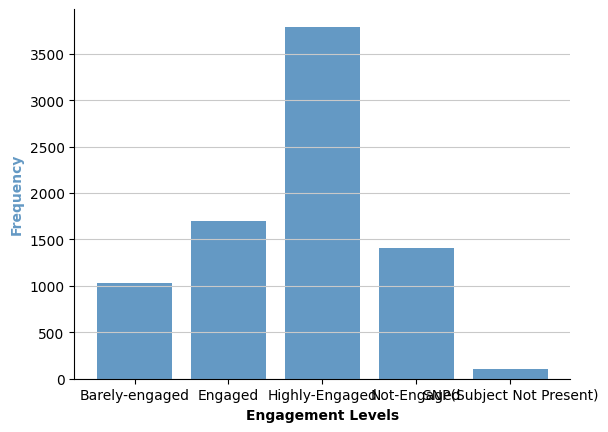

In [25]:
import matplotlib.pyplot as plt

# Prepare data for visualization
engagement_levels = []
features_list = []

# Extract engagement labels and features
for xy in Xy_1:
    features_list.append(xy[1])  # Extract features
    engagement_levels.append(xy[2])  # Extract engagement label

# Convert the engagement levels to a NumPy array
engagement_levels = np.array(engagement_levels)

# Unique engagement levels and their counts
unique_levels, counts = np.unique(engagement_levels, return_counts=True)

# Visualization 1: Frequency of Engagement Levels
fig, ax1 = plt.subplots()

# Bar plot showing the frequency of each engagement level
ax1.bar(unique_levels, counts, color='#6499c4')

# Customize the plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Engagement Levels', weight='bold')
ax1.set_ylabel('Frequency', color='#6499c4', weight='bold')
ax1.yaxis.grid(color='#c9c9c9')

plt.show()